<a href="https://colab.research.google.com/github/sinJiNi1001/Pest-Identification/blob/main/Morphological_similarity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os
import torch
import numpy as np
from PIL import Image
from transformers import ViTFeatureExtractor, ViTModel
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import euclidean_distances, cosine_similarity
import time

# --- Configuration and Setup ---

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# !! IMPORTANT !!
# 1. Update this path to your actual dataset directory containing class folders.
dataset_path = "/content/drive/MyDrive/Pests_dataset ORIGINAL/Dataset"
if not os.path.exists(dataset_path):
    print(f"Warning: Dataset path not found at {dataset_path}. Using mock data for demonstration.")

# Define class names for indexing
try:
    classes = sorted(os.listdir(dataset_path))
except FileNotFoundError:
    # Use mock classes if path is invalid for demonstration
    classes = ['Aphid', 'Armyworm', 'Beetle', 'Bollworm', 'Grasshopper',
               'Locust', 'Mealybug', 'Stemborer', 'Weevil', 'Whitefly']

print(f"Detected/Mock Classes: {classes}")

# Load ViT model (used as the feature extraction backbone)
print("Loading ViT Model...")
try:
    feature_extractor = ViTFeatureExtractor.from_pretrained("google/vit-base-patch16-224")
    vit_model = ViTModel.from_pretrained("google/vit-base-patch16-224").to(device)
    vit_model.eval()
except Exception as e:
    print(f"Error loading ViT model: {e}. Check internet connection or library installation.")
    exit()

# --- Feature Extraction Functions ---

def transform_image(image_path):
    """Loads and preprocesses an image for ViT input."""
    img = Image.open(image_path).convert('RGB')
    # feature_extractor outputs pixel_values in the correct format (tensor)
    img_tensor = feature_extractor(images=img, return_tensors="pt")['pixel_values'].to(device)
    return img_tensor

def extract_features(image_path):
    """
    Extracts the feature vector (embedding) from the ViT model.
    In a Siamese network, this output acts as the embedding vector (E).
    """
    img_tensor = transform_image(image_path)
    with torch.no_grad():
        # Use the [CLS] token's features, which represents the aggregate embedding
        features = vit_model(img_tensor).last_hidden_state[:, 0, :]
    return features.squeeze().cpu().numpy()

# --- Similarity Functions ---

def calculate_similarity(embedding_a, embedding_b):
    """
    Calculates Euclidean distance (Dissimilarity) and Cosine Similarity.
    Euclidean distance is what the Triplet Loss tries to minimize for similar samples.
    """
    # 1. Euclidean Distance (Dissimilarity)
    # Lower value means higher similarity
    dist = euclidean_distances([embedding_a], [embedding_b])[0][0]

    # 2. Cosine Similarity (Similarity)
    # Higher value (closer to 1) means higher similarity
    # Cosine Similarity measures the angle between vectors (shape/pattern similarity)
    sim = cosine_similarity([embedding_a], [embedding_b])[0][0]

    return dist, sim

# --- Data Preparation and Mocking ---

def prepare_data(data_path):
    """Iterates through the dataset and extracts ViT embeddings."""
    X, y = [], []
    if not os.path.exists(data_path):
        print("Using mock data: Cannot extract features.")
        # Return mock features for demonstration if path is missing
        return np.random.rand(50, 768), np.random.randint(0, len(classes), 50)

    print("\nStarting feature extraction (this may take time)...")
    for class_idx, class_name in enumerate(classes):
        class_folder = os.path.join(data_path, class_name)
        if not os.path.isdir(class_folder):
            continue

        # Only process a few images per class to keep runtime reasonable
        sample_images = os.listdir(class_folder)[:5]
        print(f"Processing class: {class_name} ({len(sample_images)} samples)")

        for image_name in sample_images:
            image_path = os.path.join(class_folder, image_name)
            try:
                feature_vector = extract_features(image_path)
                X.append(feature_vector)
                y.append(class_idx)
            except Exception as e:
                print(f"Error processing {image_path}: {e}")

    X = np.array(X)
    y = np.array(y)
    print(f"Total samples processed: {len(X)}")
    return X, y

# --- Main Analysis Execution ---

def run_morphological_analysis():
    X_embeddings, y_labels = prepare_data(dataset_path)

    if len(X_embeddings) == 0:
         print("Error: No data or mock data generated. Aborting analysis.")
         return

    # --- DEMONSTRATION OF SIMILARITY CALCULATION ---

    # 1. Select two samples from the SAME class (Expected High Similarity)
    class_idx_1 = 0
    class_name_1 = classes[class_idx_1]

    # Find indices for this class
    indices_c1 = np.where(y_labels == class_idx_1)[0]

    if len(indices_c1) >= 2:
        idx_a = indices_c1[0]
        idx_p = indices_c1[1]

        emb_a = X_embeddings[idx_a]
        emb_p = X_embeddings[idx_p]

        dist_same, sim_same = calculate_similarity(emb_a, emb_p)

        print("\n" + "="*50)
        print(f"TEST 1: SAME CLASS MORPHOLOGICAL SIMILARITY")
        print(f"Comparing two samples from: {class_name_1}")
        print(f"Euclidean Distance (Dissimilarity): {dist_same:.4f} (Lower is Better)")
        print(f"Cosine Similarity (Similarity):     {sim_same:.4f} (Closer to 1 is Better)")
        print("="*50)
    else:
        print("\nSkipping Test 1: Not enough samples for same-class comparison.")

    # 2. Select two samples from DIFFERENT classes (Expected Low Similarity)
    class_idx_2 = 1
    class_name_2 = classes[class_idx_2]

    # Find first index for the second class
    indices_c2 = np.where(y_labels == class_idx_2)[0]

    if len(indices_c1) >= 1 and len(indices_c2) >= 1:
        idx_a = indices_c1[0] # Sample from class 1
        idx_n = indices_c2[0] # Sample from class 2 (Negative)

        emb_a = X_embeddings[idx_a]
        emb_n = X_embeddings[idx_n]

        dist_diff, sim_diff = calculate_similarity(emb_a, emb_n)

        print("\n" + "="*50)
        print(f"TEST 2: DIFFERENT CLASS MORPHOLOGICAL SIMILARITY")
        print(f"Comparing: {class_name_1} vs {class_name_2}")
        print(f"Euclidean Distance (Dissimilarity): {dist_diff:.4f} (Higher is Better)")
        print(f"Cosine Similarity (Similarity):     {sim_diff:.4f} (Closer to 0/-1 is Better)")
        print("="*50)
    else:
         print("\nSkipping Test 2: Not enough samples for different-class comparison.")


if __name__ == "__main__":
    run_morphological_analysis()


Detected/Mock Classes: ['aphids', 'army worm', 'ballwarm', 'beetle', 'grasshopper', 'mites', 'red spider', 'sawfly', 'stem borer', 'whitefly']
Loading ViT Model...


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/transformers/models/vit/feature_extraction_vit.py:30: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Starting feature extraction (this may take time)...
Processing class: aphids (5 samples)
Processing class: army worm (5 samples)
Processing class: ballwarm (5 samples)
Processing class: beetle (5 samples)
Processing class: grasshopper (5 samples)
Processing class: mites (5 samples)
Processing class: red spider (5 samples)
Processing class: sawfly (5 samples)
Processing class: stem borer (5 samples)
Processing class: whitefly (5 samples)
Total samples processed: 50

TEST 1: SAME CLASS MORPHOLOGICAL SIMILARITY
Comparing two samples from: aphids
Euclidean Distance (Dissimilarity): 29.2611 (Lower is Better)
Cosine Similarity (Similarity):     0.3427 (Closer to 1 is Better)

TEST 2: DIFFERENT CLASS MORPHOLOGICAL SIMILARITY
Comparing: aphids vs army worm
Euclidean Distance (Dissimilarity): 29.7745 (Higher is Better)
Cosine Similarity (Similarity):     0.3437 (Closer to 0/-1 is Better)


Detected Classes: ['aphids', 'army worm', 'ballwarm', 'beetle', 'grasshopper', 'mites', 'red spider', 'sawfly', 'stem borer', 'whitefly']
Loading ViT Model and Feature Extractor...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/transformers/models/vit/feature_extraction_vit.py:30: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



--- STARTING SIAMESE NETWORK TRAINING ---
Training for 5 epochs with margin=1.0...
Epoch 1/5 | Avg Loss: 0.4495 | Time: 1552.82s
Epoch 2/5 | Avg Loss: 0.2777 | Time: 1007.64s
Epoch 3/5 | Avg Loss: 0.2522 | Time: 698.99s
Epoch 4/5 | Avg Loss: 0.1841 | Time: 490.94s
Epoch 5/5 | Avg Loss: 0.1736 | Time: 396.73s
Training complete. Embeddings are now morphologically meaningful.

Extracting final embeddings for analysis...

Successfully extracted 10454 trained embeddings.

--- EVALUATING INTER-CLASS MORPHOLOGICAL SIMILARITY ---


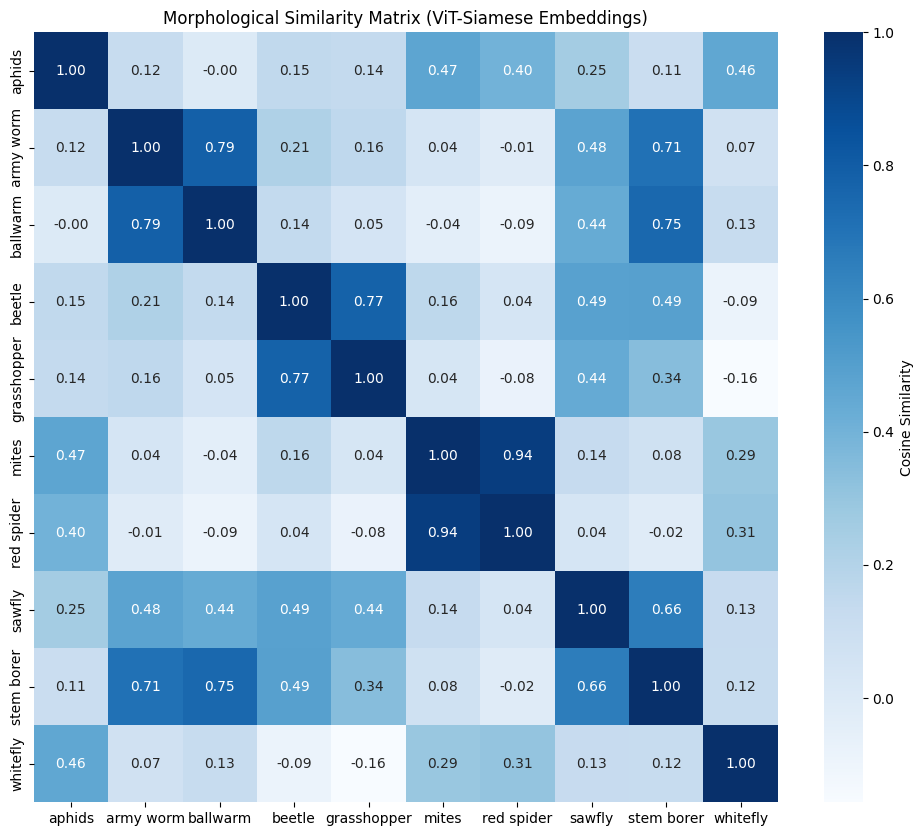

Morphological Similarity Matrix generated (1.0 = most similar, 0.0 = least similar).

--- EVALUATING CLASSIFICATION ACCURACY ---
Classification Accuracy on Test Set: 90.96%


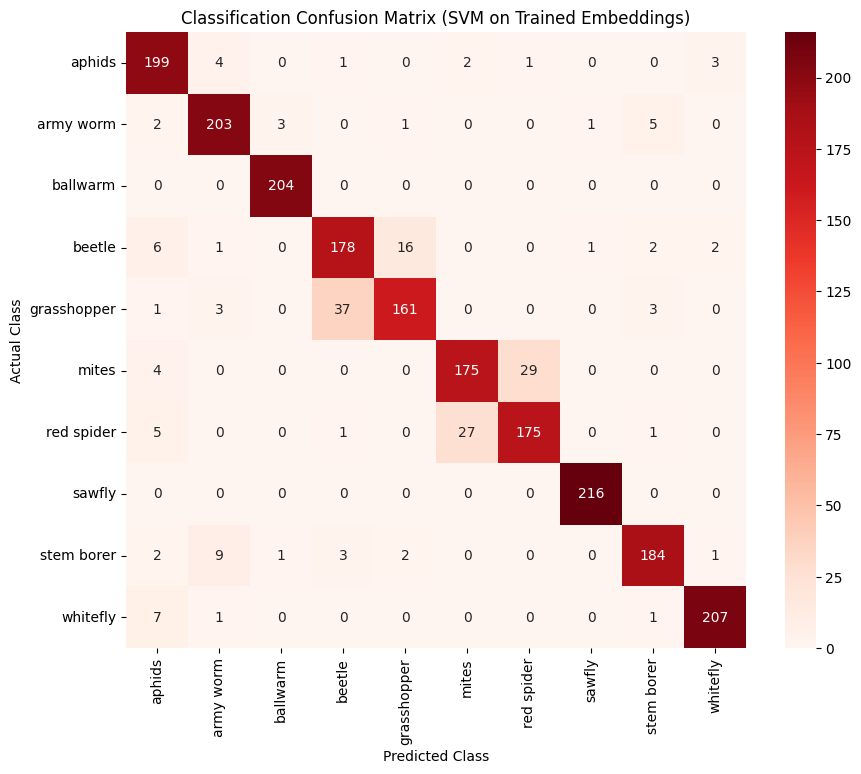

Confusion Matrix generated.


In [1]:
import os
import torch
import numpy as np
from PIL import Image
from transformers import ViTFeatureExtractor, ViTModel
from sklearn.metrics.pairwise import euclidean_distances, cosine_similarity
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import random
import time

# --- Configuration and Setup ---

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# !! IMPORTANT !! Update this path to your actual dataset directory containing class folders.
# If this path is invalid, the script will crash as training requires real images.
dataset_path = "/content/drive/MyDrive/Pests_dataset ORIGINAL/Dataset"

# Define class names for indexing (using user's detected classes)
classes = ['aphids', 'army worm', 'ballwarm', 'beetle', 'grasshopper', 'mites', 'red spider', 'sawfly', 'stem borer', 'whitefly']
print(f"Detected Classes: {classes}")
NUM_CLASSES = len(classes)
EMBEDDING_DIM = 128 # The dimension of the final learned morphological embedding

# Load ViT model (used as the feature extraction backbone)
print("Loading ViT Model and Feature Extractor...")
feature_extractor = ViTFeatureExtractor.from_pretrained("google/vit-base-patch16-224")
vit_model_base = ViTModel.from_pretrained("google/vit-base-patch16-224").to(device)

# --- PyTorch Model for Siamese Network ---
class SiameseViT(nn.Module):
    """
    ViT Backbone for Triplet/Siamese Learning.
    Fine-tunes ViT to produce morphologically meaningful embeddings.
    """
    def __init__(self, vit_model):
        super(SiameseViT, self).__init__()
        self.vit = vit_model
        # Projection head to map 768 features to the final 128-D embedding
        self.embedding_head = nn.Linear(768, EMBEDDING_DIM)

    def forward(self, x):
        outputs = self.vit(x)
        cls_embedding = outputs.last_hidden_state[:, 0, :]
        embedding = self.embedding_head(cls_embedding)
        return embedding

# Initialize the trainable Siamese ViT
siamese_model = SiameseViT(vit_model_base).to(device)


# --- PyTorch Triplet Dataset and Dataloader ---

class PestTripletDataset(Dataset):
    """Generates (Anchor, Positive, Negative) triplets on the fly."""
    def __init__(self, data_path, classes, feature_extractor):
        self.classes = classes
        self.class_to_idx = {name: i for i, name in enumerate(classes)}
        self.idx_to_class = {i: name for i, name in enumerate(classes)}
        self.feature_extractor = feature_extractor

        # Structure: {class_idx: [list of image paths]}
        self.data_by_class = {i: [] for i in range(NUM_CLASSES)}
        for class_name in classes:
            class_folder = os.path.join(data_path, class_name)
            idx = self.class_to_idx[class_name]
            if os.path.isdir(class_folder):
                # Filter out non-image files and ensure minimum data for training
                img_files = [os.path.join(class_folder, f) for f in os.listdir(class_folder) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
                self.data_by_class[idx].extend(img_files)

        # Create a list of all available image paths for easy indexing of Anchors
        self.all_image_paths = [(path, self.class_to_idx[os.path.basename(os.path.dirname(path))])
                                for paths in self.data_by_class.values() for path in paths]

    def __len__(self):
        # We can draw many triplets, but limit to prevent infinite iteration
        return len(self.all_image_paths) * 5

    def get_image_tensor(self, img_path):
        """Loads and transforms a single image path to a tensor."""
        img = Image.open(img_path).convert('RGB')
        tensor = self.feature_extractor(images=img, return_tensors="pt")['pixel_values'].squeeze(0)
        return tensor

    def __getitem__(self, idx):
        # 1. Select Anchor (A)
        # Use modulo to cycle through all available images as Anchors
        anchor_path, anchor_class_idx = self.all_image_paths[idx % len(self.all_image_paths)]

        # 2. Select Positive (P): Randomly select another image from the same class
        positive_paths = [p for p in self.data_by_class[anchor_class_idx] if p != anchor_path]
        if not positive_paths:
            # Fallback: if only one image in class, select a random different one and try again
            return self.__getitem__(random.randint(0, len(self) - 1))
        positive_path = random.choice(positive_paths)

        # 3. Select Negative (N): Randomly select an image from a different class
        negative_class_idx = random.choice([i for i in range(NUM_CLASSES) if i != anchor_class_idx])
        negative_path = random.choice(self.data_by_class[negative_class_idx])

        # Convert to tensors
        try:
            anchor_tensor = self.get_image_tensor(anchor_path)
            positive_tensor = self.get_image_tensor(positive_path)
            negative_tensor = self.get_image_tensor(negative_path)
            return anchor_tensor, positive_tensor, negative_tensor
        except Exception as e:
            # On I/O or other error, retry with a new triplet
            # print(f"Error loading image during triplet generation: {e}")
            return self.__getitem__(random.randint(0, len(self) - 1))

# --- Training Loop Implementation ---

def train_siamese_network(model, data_loader, epochs=5, margin=1.0):
    """Implements the full Siamese training with Triplet Loss."""
    print("\n--- STARTING SIAMESE NETWORK TRAINING ---")
    print(f"Training for {epochs} epochs with margin={margin}...")

    optimizer = optim.Adam(model.parameters(), lr=1e-5)
    triplet_loss = nn.TripletMarginLoss(margin=margin, p=2)

    model.train()

    for epoch in range(epochs):
        total_loss = 0
        start_time = time.time()

        # Use a fixed number of batches per epoch to manage runtime
        num_batches_to_run = 50

        for batch_idx, (anchor, positive, negative) in enumerate(data_loader):
            if batch_idx >= num_batches_to_run:
                break

            # Move tensors to the appropriate device
            anchor = anchor.to(device)
            positive = positive.to(device)
            negative = negative.to(device)

            # 1. Get embeddings for the triplet
            emb_a = model(anchor)
            emb_p = model(positive)
            emb_n = model(negative)

            # 2. Calculate the loss
            loss = triplet_loss(emb_a, emb_p, emb_n)

            # 3. Backpropagate and update weights
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / num_batches_to_run
        elapsed_time = time.time() - start_time
        print(f"Epoch {epoch+1}/{epochs} | Avg Loss: {avg_loss:.4f} | Time: {elapsed_time:.2f}s")

    print("Training complete. Embeddings are now morphologically meaningful.")


# --- Feature Extraction (After Training) ---

def extract_all_embeddings(model, dataset_path, classes):
    """Extracts final 128-D embeddings and labels from all images."""
    X_embeddings, y_labels = [], []
    all_paths = []

    print("\nExtracting final embeddings for analysis...")
    model.eval()

    for class_idx, class_name in enumerate(classes):
        class_folder = os.path.join(dataset_path, class_name)
        if not os.path.isdir(class_folder): continue

        for image_name in os.listdir(class_folder):
            if not image_name.lower().endswith(('.png', '.jpg', '.jpeg')): continue
            image_path = os.path.join(class_folder, image_name)

            try:
                img_tensor = transform_image(image_path)
                with torch.no_grad():
                    embedding = model(img_tensor).squeeze().cpu().numpy()
                X_embeddings.append(embedding)
                y_labels.append(class_idx)
                all_paths.append(image_path)
            except Exception:
                pass # Skip problematic images

    return np.array(X_embeddings), np.array(y_labels)

def transform_image(image_path):
    """Loads and preprocesses an image for ViT input."""
    img = Image.open(image_path).convert('RGB')
    img_tensor = feature_extractor(images=img, return_tensors="pt")['pixel_values'].to(device)
    return img_tensor

# --- Evaluation Functions ---

def evaluate_similarity_matrix(X_embeddings, y_labels, classes):
    """Calculates and visualizes the mean similarity between all pest classes."""
    print("\n--- EVALUATING INTER-CLASS MORPHOLOGICAL SIMILARITY ---")

    # 1. Calculate the mean embedding for each class
    mean_embeddings = []
    for i in range(NUM_CLASSES):
        class_embeddings = X_embeddings[y_labels == i]
        if len(class_embeddings) > 0:
            mean_embeddings.append(np.mean(class_embeddings, axis=0))
        else:
            mean_embeddings.append(np.zeros(EMBEDDING_DIM)) # Placeholder for empty classes

    mean_embeddings = np.array(mean_embeddings)

    # 2. Calculate Cosine Similarity Matrix
    similarity_matrix = cosine_similarity(mean_embeddings)

    plt.figure(figsize=(12, 10))
    sns.heatmap(similarity_matrix, annot=True, fmt=".2f", cmap="Blues",
                xticklabels=classes, yticklabels=classes, cbar_kws={'label': 'Cosine Similarity'})
    plt.title('Morphological Similarity Matrix (ViT-Siamese Embeddings)')
    plt.show()
    print("Morphological Similarity Matrix generated (1.0 = most similar, 0.0 = least similar).")

def evaluate_classification(X_embeddings, y_labels, classes):
    """
    Trains a simple SVM classifier on the learned embeddings to evaluate their separability.
    """
    print("\n--- EVALUATING CLASSIFICATION ACCURACY ---")

    # Check if there is enough data for a split
    if len(X_embeddings) < 2 * NUM_CLASSES:
        print("Not enough data to run classification evaluation. Skipping.")
        return

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X_embeddings, y_labels, test_size=0.2, random_state=42, stratify=y_labels)

    # Train a simple classifier (SVM is robust for feature vectors)
    svc_classifier = SVC(kernel='linear', random_state=42)
    svc_classifier.fit(X_train, y_train)

    # Predict and evaluate
    y_pred = svc_classifier.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)

    print(f"Classification Accuracy on Test Set: {accuracy * 100:.2f}%")

    # Plot Confusion Matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Reds',
                xticklabels=classes, yticklabels=classes)
    plt.title('Classification Confusion Matrix (SVM on Trained Embeddings)')
    plt.xlabel('Predicted Class')
    plt.ylabel('Actual Class')
    plt.show()
    print("Confusion Matrix generated.")


# --- Main Analysis Execution ---

def run_morphological_analysis():

    # Check if the dataset path is valid before attempting training
    if not os.path.exists(dataset_path):
        print("\nFATAL ERROR: Dataset path not found. Cannot proceed with training.")
        print("Please update the 'dataset_path' variable with a valid location.")
        return

    # --- STEP 1: PREPARE DATASET AND TRAIN ---
    triplet_dataset = PestTripletDataset(dataset_path, classes, feature_extractor)
    if not triplet_dataset.all_image_paths:
        print("\nFATAL ERROR: No images found in the dataset folders. Cannot proceed with training.")
        return

    triplet_dataloader = DataLoader(triplet_dataset, batch_size=32, shuffle=True)

    # Train the Siamese Network
    train_siamese_network(siamese_model, triplet_dataloader, epochs=5, margin=1.0)

    # --- STEP 2: EXTRACT TRAINED EMBEDDINGS ---
    X_trained_embeddings, y_labels = extract_all_embeddings(siamese_model, dataset_path, classes)

    if len(X_trained_embeddings) == 0:
        print("\nFATAL ERROR: Could not extract any embeddings after training. Aborting evaluation.")
        return

    print(f"\nSuccessfully extracted {len(X_trained_embeddings)} trained embeddings.")

    # --- STEP 3: EVALUATE SIMILARITY ---
    evaluate_similarity_matrix(X_trained_embeddings, y_labels, classes)

    # --- STEP 4: EVALUATE CLASSIFICATION ---
    evaluate_classification(X_trained_embeddings, y_labels, classes)


if __name__ == "__main__":
    run_morphological_analysis()


In [3]:
import joblib

# Save the whole model object (not just weights)
joblib.dump(siamese_model, "siamese_vit_model.pkl")
print("✅ Siamese ViT saved as 'siamese_vit_model.pkl'")


✅ Siamese ViT saved as 'siamese_vit_model.pkl'


In [4]:
loaded_model = joblib.load("siamese_vit_model.pkl")
loaded_model.to(device)
loaded_model.eval()
print("✅ Loaded Siamese ViT from joblib")


✅ Loaded Siamese ViT from joblib
